In [29]:
import os, torch
#from torchdiffeq import odeint_adjoint as odeint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import sys
sys.path.append('../')
from typing import Tuple, Any

%load_ext autoreload
%autoreload 2


import interflow as itf
import interflow.prior as prior
import interflow.fabrics
import interflow.stochastic_interpolant as stochastic_interpolant
import interflow.realnvp as realnvp
from torch import autograd
from functorch import jacfwd, vmap


if torch.cuda.is_available():
    print('CUDA available, setting default tensor residence to GPU.')
    itf.util.set_torch_device('cuda')
else:
    print('No CUDA device found!')
print(itf.util.get_torch_device())


print("Torch version:", torch.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CUDA available, setting default tensor residence to GPU.
cuda
Torch version: 2.5.1


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Device] Using: {device} | CUDA_VISIBLE_DEVICES={os.environ.get('CUDA_VISIBLE_DEVICES')}")
if device.type == "cuda":
    try:
        print("[Device] GPU:", torch.cuda.get_device_name(0))
        torch.backends.cudnn.benchmark = True
    except Exception as _e:
        print("[Device] GPU name unavailable:", _e)

def move_to(obj, device=device, non_blocking=True):
    """Recursively move tensors in nested containers to device."""
    import torch
    if torch.is_tensor(obj):
        return obj.to(device=device, non_blocking=non_blocking)
    if isinstance(obj, dict):
        return {k: move_to(v, device, non_blocking) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        seq = [move_to(x, device, non_blocking) for x in obj]
        return type(obj)(seq) if isinstance(obj, tuple) else seq
    return obj

print("[Device] Helper move_to() is defined.")


[Device] Using: cuda | CUDA_VISIBLE_DEVICES=0
[Device] GPU: NVIDIA L40S
[Device] Helper move_to() is defined.


In [31]:
# --- Try moving common models/modules to the selected device ---
for _name in ['v', 'model', 'net', 'flow', 'flow_model', 'interpolant', 'b', 's']:
    if _name in globals():
        _obj = globals()[_name]
        try:
            # nn.Module or object exposing .to()
            _obj.to(device)  # type: ignore
            try:
                import torch
                p = next(_obj.parameters())
                print(f"[Move] {_name}: parameters on {p.device}")
            except Exception:
                print(f"[Move] {_name}: moved via .to(device)")
        except Exception as e:
            print(f"[Move] Skip {_name}: {e}")


[Move] v: parameters on cuda:0
[Move] interpolant: parameters on cuda:0


## Adversarial training of nonlinear SI to solve Schrödinger Bridge 

## Utility functions

In [32]:
def grab(var):
    """Take a tensor off the gpu and convert it to a numpy array on the CPU."""
    return var.detach().cpu().numpy()


def compute_likelihoods(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    eps: int,
    bs: int
) -> Tuple[torch.tensor, torch.tensor]:
    """Draw samples from the probability flow and SDE models, and compute likelihoods."""
    
    
    sde_flow = stochastic_interpolant.SDEIntegrator(
        b=b, s=s, eps=eps, interpolant=interpolant, n_save=n_save, n_likelihood=1, n_step=n_step
    )
    pflow = stochastic_interpolant.PFlowIntegrator(b=b,  
                                                  method='dopri5', 
                                                  interpolant=interpolant,
                                                  n_step=3)
    
    with torch.no_grad():
        x0_tests  = base(bs)
        xfs_sde   = sde_flow.rollout_forward(x0_tests) # [n_save x bs x dim]
        xf_sde    = grab(xfs_sde[-1].squeeze())        # [bs x dim]
        # ([1, bs, dim], [bs])
        x0s_sdeflow, _ = sde_flow.rollout_likelihood(xfs_sde[-1])
    

    logp0                  = base.log_prob(x0_tests)            # [bs]
    xfs_pflow, dlogp_pflow = pflow.rollout(x0_tests)            # [n_save x bs x dim], [n_save x bs]
    logpx_pflow            = logp0 + dlogp_pflow[-1].squeeze()  # [bs]
    xf_pflow               = grab(xfs_pflow[-1].squeeze())      # [bs x dim]


    return xf_sde, xf_pflow, logpx_pflow


def log_metrics(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    likelihood_bs: int, 
    b_loss: torch.tensor,
    s_loss: torch.tensor,
    loss: torch.tensor,
    b_grad: torch.tensor,
    s_grad: torch.tensor,
    eps: torch.tensor,
    data_dict: dict
) -> None:
    # log loss and gradient data
    b_loss   = grab(b_loss).mean(); data_dict['b_losses'].append(b_loss)
    s_loss   = grab(s_loss).mean(); data_dict['s_losses'].append(s_loss)
    loss     = grab(loss).mean(); data_dict['losses'].append(loss)
    b_grad   = grab(b_grad).mean(); data_dict['b_grads'].append(b_grad)
    s_grad   = grab(s_grad).mean(); data_dict['s_grads'].append(s_grad)

    
    # compute and log likelihood data
    _, _, logpx_pflow = compute_likelihoods(
        b, s, interpolant, n_save, n_step, eps, likelihood_bs)
    
    logpx_pflow = grab(logpx_pflow).mean(); data_dict['logps_pflow'].append(logpx_pflow)
    
    
def make_plots(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int, ## number of sde steps in [0,1]
    likelihood_bs: int,
    counter: int,
    metrics_freq: int,
    eps: torch.tensor,
    data_dict: dict
) -> None:
    """Make plots to visualize samples and evolution of the likelihood."""
    # compute likelihood and samples for SDE and probability flow.
    xf_sde, xf_pflow, logpx_pflow = compute_likelihoods(
        b, s, interpolant, n_save, n_step, eps, likelihood_bs
    )


    ### plot the loss, test logp, and samples from interpolant flow
    fig, axes = plt.subplots(1,2, figsize=(16,4))
    #print("EPOCH:", counter)
    #print("LOSS, GRAD:", loss, b_grad, s_grad)


    ## plot loss over time.
    #nsaves = len(data_dict['losses'])
    #epochs = np.arange(nsaves)*metrics_freq
    #axes[0].plot(epochs, data_dict['losses'], label=" b + s")
    #axes[0].plot(epochs, data_dict['b_losses'], label="b")
    #xes[0].plot(epochs, data_dict['s_losses'], label = "s" )
    #xes[0].set_title("LOSS")
    #axes[0].legend()


    # plot samples from SDE.
    axes[0].scatter(
        xf_sde[:,0], xf_sde[:,1], vmin=0.0, vmax=0.05, alpha = 0.2)
    axes[0].set_xlim(-5,5)
    axes[0].set_ylim(-6.5,6.5)
    axes[0].set_title("Samples from SDE", fontsize=14)


    # plot samples from pflow
    axes[1].scatter(
        xf_pflow[:,0], xf_pflow[:,1], vmin=0.0, vmax=0.05, alpha = 0.2, c=grab(torch.exp(logpx_pflow).detach()))
    axes[1].set_xlim(-5,5)
    axes[1].set_ylim(-6.5,6.5)
    axes[1].set_title("Samples from PFlow", fontsize=14)


    ## plot likelihood estimates.
    #axes[3].plot(epochs, data_dict['logps_pflow'],   label='pflow', color='purple')
    #axes[3].set_title(r"$\log p$ from PFlow")
    #axes[3].legend(loc='best')
    #axes[3].set_ylim(-7,0)


    fig.suptitle(r"$\epsilon = $" + str(grab(eps)),  fontsize=16, y = 1.05)
    plt.show()
    
    


def train_step(
    bs: int,
    interpolant: stochastic_interpolant.Interpolant,
    opt_v: Any,
    opt_flow: Any,  # Changed from opt_T to opt_flow for clarity
    sched_v: Any, 
    sched_flow: Any,  # Changed from sched_T to sched_flow for clarity
    n_inner: int = 1,  # Number of inner minimization steps
    n_outer: int = 1,  # Number of outer maximization steps
):
    """
    Take a single step of adversarial training.
    Inner loop: minimize loss w.r.t. v
    Outer loop: maximize loss w.r.t. interpolant.flow_model
    """
    
    # Inner minimization: minimize over v
    for _ in range(n_inner):
        opt_v.zero_grad()
        
        # construct batch
        x0s = base(bs)
        x1s = target(bs)
        ts  = torch.rand(size=(bs,))
        
        # compute the loss for v minimization
        loss_v = loss_fn_v(v, x0s, x1s, ts, interpolant)
        
        # compute gradient and update v
        loss_v.backward()
        v_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(v.parameters(), float('inf'))])
        opt_v.step()
    
    # Outer maximization: maximize over interpolant.flow_model
    for _ in range(n_outer):
        opt_flow.zero_grad()
        
        # construct batch
        x0s = base(bs)
        x1s = target(bs)
        ts  = torch.rand(size=(bs,))
        
        # compute the loss for flow model maximization
        loss_flow = loss_fn_v(v, x0s, x1s, ts, interpolant)
        
        # compute gradient for maximization (negative of minimization gradient)
        (-loss_flow).backward()  # Negative for maximization
        flow_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(interpolant.flow_model.parameters(), float('inf'))])
        opt_flow.step()
    
    # Step the schedulers
    sched_v.step()
    sched_flow.step()
    
    # Return the final loss values and gradients for logging
    return loss_v.detach(), loss_flow.detach(), v_grad.detach(), flow_grad.detach()

def train_step_v_only(
    bs: int,
    interpolant: stochastic_interpolant.Interpolant,
    opt_v: Any,
    sched_v: Any, 
    n: int = 1,  # Number of inner minimization steps
):
    """
    Take a single step of adversarial training.
    Inner loop: minimize loss w.r.t. v
    Outer loop: maximize loss w.r.t. interpolant.flow_model
    """

    # ——— freeze flow_model parameters
    flow_params = list(interpolant.flow_model.parameters())
    _prev_flags = [p.requires_grad for p in flow_params]
    for p in flow_params:
        p.requires_grad_(False)

    # minimize over v
    for _ in range(n):
        opt_v.zero_grad()

        # construct batch
        x0s = base(bs)
        x1s = target(bs)
        ts  = torch.rand(size=(bs,))

        # compute the loss for v minimization
        loss_v = loss_fn_v(v, x0s, x1s, ts, interpolant)

        # compute gradient and update v
        loss_v.backward()
        v_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(v.parameters(), float('inf'))])
        opt_v.step()
        
    # Step the schedulers
    sched_v.step()

    # Return the final loss values and gradients for logging
    return loss_v.detach(), v_grad.detach()

### Define target

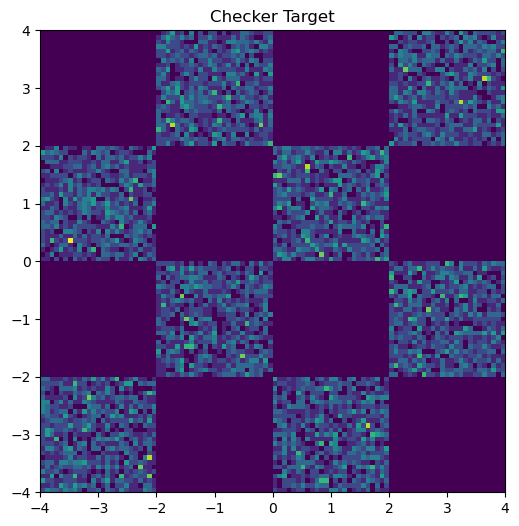

Batch Shape: (10000, 2)


In [33]:
ndim = 2
def target(bs):
    x1 = torch.rand(bs, dtype=torch.float32) * 4 - 2
    x2_ = torch.rand(bs, dtype=torch.float32) - torch.randint(2, (bs,), dtype=torch.float32) * 2
    x2 = x2_ + (torch.floor(x1) % 2)
    return (torch.cat([x1[:, None], x2[:, None]], 1) * 2)


target_samples = grab(target(10000))


fig = plt.figure(figsize=(6,6))
plt.hist2d(target_samples[:,0], target_samples[:,1], bins = 100, range=[[-4,4],[-4,4]]);
plt.title("Checker Target")
plt.show()


print("Batch Shape:", target_samples.shape)
# target_logp_est = target.log_prob(target(10000)).mean()

### Define Base Distribution

In [34]:
base_loc     = torch.zeros(ndim, device=device, dtype=torch.float32)
base_var     = torch.ones(ndim, device=device, dtype=torch.float32)
base         = prior.SimpleNormal(base_loc, 1.0*base_var)
base_samples = grab(torch.tensor(base(20000),dtype=torch.float32))









/tmp/ipykernel_2797236/2389798472.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  base_samples = grab(torch.tensor(base(20000),dtype=torch.float32))


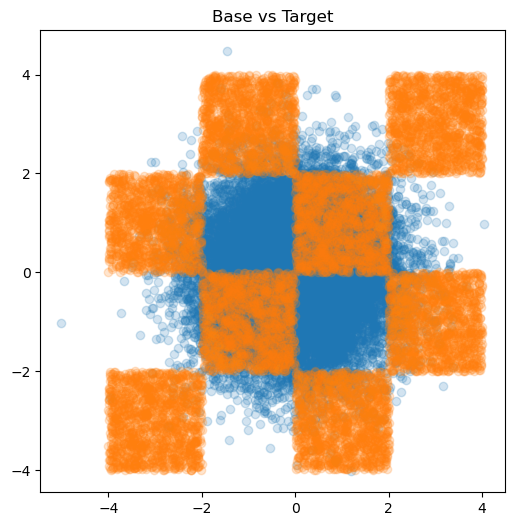

In [35]:
fig = plt.figure(figsize=(6,6,))
plt.scatter(base_samples[:,0], base_samples[:,1],  label = 'base', alpha = 0.2);
plt.scatter(target_samples[:,0], target_samples[:,1], alpha = 0.2);
plt.title("Bimodal Target")
plt.title("Base vs Target")
plt.show()

### Define Interpolant: A nonlinear interpolant.

In [36]:
path = "nonlinear"
flow_config = {
    "num_layers": 4,
    "time_embed_dim": 128,
    "hidden": 128,
    "mlp_blocks": 4,
    "activation": "gelu",
    "use_layernorm": False,
    "use_permutation": True
    }

data_type = "vector"
data_dim = 2

interpolant = stochastic_interpolant.Interpolant(path=path, gamma_type = None,\
    flow_config=flow_config, data_type=data_type, data_dim=data_dim)

# check trainable parameters
# These should be the same object
print(f"self.It is bound to flow_model: {interpolant.It.__self__ is interpolant.flow_model}")

# Check trainable parameters
trainable_params = sum(p.numel() for p in interpolant.flow_model.parameters())
print(f"Flow model has {trainable_params:,} trainable parameters")





self.It is bound to flow_model: True
Flow model has 265,736 trainable parameters


### Define losses for v

In [37]:
loss_fn_v = stochastic_interpolant.make_loss(method='shared', interpolant = interpolant, loss_type='one-sided-v')

### Define optimizers

In [38]:
base_lr_v      = 2e-3
base_lr_flow   = 2e-3  # learning rate for flow model (T_t)
hidden_sizes = [256, 256, 256, 256]
in_size      = (ndim+1)
out_size     = (ndim)
inner_act    = 'relu'
final_act    = 'none'
print_model  = False


v         = itf.fabrics.make_fc_net(hidden_sizes=hidden_sizes, in_size=in_size, out_size=out_size, inner_act=inner_act, final_act=final_act)
opt_v     = torch.optim.Adam(v.parameters(), lr=base_lr_v)
opt_flow  = torch.optim.Adam(interpolant.flow_model.parameters(), lr=base_lr_flow)
sched_v   = torch.optim.lr_scheduler.StepLR(optimizer=opt_v, step_size=1500, gamma=0.4)
sched_flow = torch.optim.lr_scheduler.StepLR(optimizer=opt_flow, step_size=1500, gamma=0.4)


eps          = torch.tensor(0)
N_epoch      = 15
plot_bs      = 5000  # number of samples to use when plotting
bs           = 4    # Increased batch size for better GPU utilization
metrics_freq = 50    # how often to log metrics, e.g. if logp is not super cheap don't do it everytime
plot_freq    = 500   # how often to plot
n_save       = 10    # how often to checkpoint SDE integrator
loss_fac     = 4.0   # ratio of learning rates for w to v
n_step       = 100   # number of steps taken by the SDE in [0,1]
n_inner      = 3     # Reduced inner minimization steps for v (was 5)
n_outer      = 3     # Reduced outer maximization steps for flow model (was 5)

# Enable GPU optimizations
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True

if print_model:
    print("Here's the model v:", v)

In [39]:
data_dict = {
    'losses': [],
    'v_losses': [],
    'flow_losses': [],  # Changed from T_losses
    'v_grads': [],
    'flow_grads': [],   # Changed from T_grads
    'times': [],
    'logps_pflow': [],
}

counter = 1

## Training Loop with Adversarial Training

In [40]:
# Example training loop with parameter verification
import copy

# Store initial parameters
initial_v_params = copy.deepcopy(list(v.parameters())[0].data.clone())
initial_flow_params = copy.deepcopy(list(interpolant.flow_model.parameters())[0].data.clone())

for epoch in range(N_epoch):  # Run for a few epochs to test
    # Take a training step with adversarial training
    loss_v, loss_flow, v_grad, flow_grad = train_step(
        bs=bs,
        interpolant=interpolant,
        opt_v=opt_v,
        opt_flow=opt_flow,
        sched_v=sched_v,
        sched_flow=sched_flow,
        n_inner=n_inner,
        n_outer=n_outer
    )
    
    # Log metrics
    data_dict['v_losses'].append(grab(loss_v).mean())
    data_dict['flow_losses'].append(grab(loss_flow).mean())
    data_dict['v_grads'].append(grab(v_grad).mean())
    data_dict['flow_grads'].append(grab(flow_grad).mean())
    data_dict['losses'].append(grab(loss_v).mean())  # Use v loss as the main loss
    
    # Print with gradient info for verification
    print(f"Epoch {epoch+1}: v_loss={loss_v.detach().item():.4f}, "
        f"flow_loss={loss_flow.detach().item():.4f}, "
        f"v_grad={v_grad.detach().item():.4f}, "
        f"flow_grad={flow_grad.detach().item():.4f}")    
    counter += 1

# Verify parameters were updated
final_v_params = list(v.parameters())[0].data.clone()
final_flow_params = list(interpolant.flow_model.parameters())[0].data.clone()

v_change = torch.norm(final_v_params - initial_v_params).item()
flow_change = torch.norm(final_flow_params - initial_flow_params).item()

print(f"\nParameter updates verified:")
print(f"  v model parameters changed by: {v_change:.6f}")
print(f"  flow model parameters changed by: {flow_change:.6f}")

fallback is used
fallback is used
fallback is used
fallback is used
fallback is used
fallback is used
Epoch 1: v_loss=-0.1653, flow_loss=-2.3960, v_grad=4.8284, flow_grad=69.5725
fallback is used
fallback is used
fallback is used
fallback is used
fallback is used
fallback is used
Epoch 2: v_loss=17.9090, flow_loss=-6.8360, v_grad=104.7133, flow_grad=193.0621
fallback is used
fallback is used
fallback is used
fallback is used
fallback is used
fallback is used
Epoch 3: v_loss=-12.9132, flow_loss=12.6564, v_grad=65.8059, flow_grad=153.7076
fallback is used
fallback is used
fallback is used
fallback is used
fallback is used
fallback is used
Epoch 4: v_loss=41.4429, flow_loss=36.6989, v_grad=185.4610, flow_grad=271.1600
fallback is used
fallback is used
fallback is used
fallback is used
fallback is used
fallback is used
Epoch 5: v_loss=19.7981, flow_loss=-172.1789, v_grad=224.1008, flow_grad=1060.4141
fallback is used
fallback is used
fallback is used
fallback is used
fallback is used
fallb

In [53]:
x0s = base(2)
x1s = target(2)
ts = torch.rand(size=(2,))
#print(x0s.shape)
#x0s[1].shape
#dtIt_method(interpolant,ts,x0s,x1s)
x1s.shape

torch.Size([2, 2])

In [46]:
a      = lambda t: torch.cos(0.5*math.pi*t)
adot   = lambda t: -0.5*math.pi*torch.sin(0.5*math.pi*t)
b      = lambda t: torch.sin(0.5*math.pi*t)
bdot   = lambda t: 0.5*math.pi*torch.cos(0.5*math.pi*t)

In [48]:
a_t = a(ts)
a_t = a_t.view(-1, 1).expand(2, -1)
print(a_t)
print(x0s)

tensor([[0.2369],
        [0.7793]])
tensor([[-0.6849, -0.2893],
        [ 0.4321,  0.7707]])


In [49]:
a_t*x0s

tensor([[-0.1623, -0.0685],
        [ 0.3367,  0.6006]])

In [42]:
os.makedirs("checkpoints", exist_ok=True)

torch.save({
    "v": v.state_dict(),
    "flow": interpolant.flow_model.state_dict(),
}, "checkpoints/weights_only.pt")

#ckpt = torch.load("checkpoints/weights_only.pt", map_location=device)
#v.load_state_dict(ckpt["v"])
#interpolant.flow_model.load_state_dict(ckpt["flow"])

### Post Training

In [34]:
ckpt = torch.load("checkpoints/weights_only.pt", map_location=device)
v.load_state_dict(ckpt["v"])
interpolant.flow_model.load_state_dict(ckpt["flow"])

/tmp/ipykernel_3554308/1742592006.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("checkpoints/weights_only.pt", map_location=device)


<All keys matched successfully>

### Train v

In [ ]:
# Optimized Training Parameters for A100
base_lr_v      = 2e-3
base_lr_flow   = 2e-3  # learning rate for flow model (T_t)
hidden_sizes = [256, 256, 256, 256]
in_size      = (ndim+1)
out_size     = (ndim)
inner_act    = 'relu'
final_act    = 'none'
print_model  = False

# Create model and optimizer
v         = itf.fabrics.make_fc_net(hidden_sizes=hidden_sizes, in_size=in_size, out_size=out_size, inner_act=inner_act, final_act=final_act)
opt_v     = torch.optim.Adam(v.parameters(), lr=base_lr_v)
opt_flow  = torch.optim.Adam(interpolant.flow_model.parameters(), lr=base_lr_flow)
sched_v   = torch.optim.lr_scheduler.StepLR(optimizer=opt_v, step_size=1500, gamma=0.4)
sched_flow = torch.optim.lr_scheduler.StepLR(optimizer=opt_flow, step_size=1500, gamma=0.4)

# OPTIMIZED PARAMETERS FOR A100
eps          = torch.tensor(0)
N_era        = 14
N_epoch      = 500
plot_bs      = 5000  # number of samples to use when plotting

# Increased batch size for better GPU utilization
bs           = 1024   # Increased from 256 to 1024 (4x larger)

metrics_freq = 50    # how often to log metrics
plot_freq    = 500   # how often to plot
n_save       = 10    # how often to checkpoint SDE integrator
loss_fac     = 4.0   # ratio of learning rates for w to v
n_step       = 100   # number of steps taken by the SDE in [0,1]

# Reduced inner steps to compensate for larger batch
n            = 25     # Reduced from 100 to 25 (4x smaller)

# Enable GPU optimizations
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True

print(f"Optimized training with batch_size={bs}, n_inner_steps={n}")
print(f"Total samples per epoch: {bs * n} = {bs*n}")

if print_model:
    print("Here's the model v:", v)

In [36]:
data_dict = {
    'v_losses': [],
    'v_grads': [],
    'times': [],
    'logps_pflow': [],
}

counter = 1

In [ ]:
# Optimized training loop with parameter update verification
import time
import copy

print("Starting optimized training with parameter verification...")
start_time = time.time()

# Store initial parameters to verify they're being updated
initial_v_params = copy.deepcopy(list(v.parameters())[0].data.clone())

for epoch in range(15):  
    epoch_start = time.time()
    
    # Store params before training step
    before_params = list(v.parameters())[0].data.clone()
    
    # Use standard training function (no mixed precision)
    loss_v, v_grad = train_step_v_only(
        bs=bs,
        interpolant=interpolant,
        opt_v=opt_v,
        sched_v=sched_v,
        n=n,
    )
    
    # Check if parameters were updated
    after_params = list(v.parameters())[0].data.clone()
    params_changed = not torch.allclose(before_params, after_params)
    
    # Log metrics
    data_dict['v_losses'].append(loss_v.mean())
    data_dict['v_grads'].append(v_grad.mean())
    
    # Print progress with verification
    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch+1}/15: v_loss={loss_v.detach().item():.4f}, "
          f"v_grad={v_grad.detach().item():.4f}, "
          f"params_updated={params_changed}, "
          f"time={epoch_time:.2f}s") 
    counter += 1

# Final verification
final_params = list(v.parameters())[0].data.clone()
total_change = torch.norm(final_params - initial_v_params).item()

total_time = time.time() - start_time
print(f"\nTraining completed successfully!")
print(f"Total parameter change from start: {total_change:.6f}")
print(f"Total training time: {total_time:.2f}s")
print(f"Average time per epoch: {total_time/15:.2f}s")

In [38]:
import gc, torch

# 1) move big modules off GPU (edit the list to match your variables)
for objname in ["v", "interpolant"]:
    if objname in globals():
        obj = globals()[objname]
        try:
            # if interpolant has a flow_model, move it too
            if hasattr(obj, "flow_model") and hasattr(obj.flow_model, "to"):
                obj.flow_model.to("cpu")
            if hasattr(obj, "to"):
                obj.to("cpu")
        except Exception as e:
            print(f"skip {objname}:", e)

# 2) delete large tensors/temps you no longer need (add your own)
for name in ["x0s","x1s","ts","out","loss_v","loss_flow","c","a","b"]:
    if name in globals():
        del globals()[name]

# 3) force collection and release cached blocks
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

# 4) check how much remains
if torch.cuda.is_available():
    print(torch.cuda.memory_summary(device=None, abbreviated=True))


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  37658 KiB |  11524 MiB |   6466 GiB |   6466 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  37658 KiB |  11524 MiB |   6466 GiB |   6466 GiB |
|---------------------------------------------------------------------------|
| Requested memory      |  37505 KiB |  11519 MiB |   6438 GiB |   6438 GiB |
|---------------------------------------------------------------